In [115]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
with open('train.json') as data_file:    
    data = json.load(data_file)

In [3]:
len(data)

39774

In [4]:
data

[{u'cuisine': u'greek',
  u'id': 10259,
  u'ingredients': [u'romaine lettuce',
   u'black olives',
   u'grape tomatoes',
   u'garlic',
   u'pepper',
   u'purple onion',
   u'seasoning',
   u'garbanzo beans',
   u'feta cheese crumbles']},
 {u'cuisine': u'southern_us',
  u'id': 25693,
  u'ingredients': [u'plain flour',
   u'ground pepper',
   u'salt',
   u'tomatoes',
   u'ground black pepper',
   u'thyme',
   u'eggs',
   u'green tomatoes',
   u'yellow corn meal',
   u'milk',
   u'vegetable oil']},
 {u'cuisine': u'filipino',
  u'id': 20130,
  u'ingredients': [u'eggs',
   u'pepper',
   u'salt',
   u'mayonaise',
   u'cooking oil',
   u'green chilies',
   u'grilled chicken breasts',
   u'garlic powder',
   u'yellow onion',
   u'soy sauce',
   u'butter',
   u'chicken livers']},
 {u'cuisine': u'indian',
  u'id': 22213,
  u'ingredients': [u'water', u'vegetable oil', u'wheat', u'salt']},
 {u'cuisine': u'indian',
  u'id': 13162,
  u'ingredients': [u'black pepper',
   u'shallots',
   u'cornflour',

In [5]:
products_num = np.array([len(i["ingredients"]) for i in data])

In [6]:
cuisine = []
ingredients = []
ingredients_num = []
for i in data:
    if len(i["ingredients"]) < 50:
        ingredients.append(" ".join(i["ingredients"]))
        cuisine.append(i["cuisine"])
        ingredients_num.append(len(i["ingredients"]))

In [7]:
df = pd.DataFrame()
df["cuisine"] = cuisine
df["ingridients"] = ingredients
df["ingredients_num"] = ingredients_num

In [8]:
df.head()

,cuisine,ingridients,ingredients_num
0,greek,romaine lettuce black olives grape tomatoes ga...,9
1,southern_us,plain flour ground pepper salt tomatoes ground...,11
2,filipino,eggs pepper salt mayonaise cooking oil green c...,12
3,indian,water vegetable oil wheat salt,4
4,indian,black pepper shallots cornflour cayenne pepper...,20


In [9]:
(df.groupby("cuisine")["ingredients_num"].mean().reset_index()
                                         .sort_values("ingredients_num", ascending=False))

,cuisine,ingredients_num
14,moroccan,12.909866
7,indian,12.705961
19,vietnamese,12.675152
2,cajun_creole,12.617076
18,thai,12.545809
10,jamaican,12.214829
3,chinese,11.982791
12,korean,11.284337
13,mexican,10.871058
17,spanish,10.423660


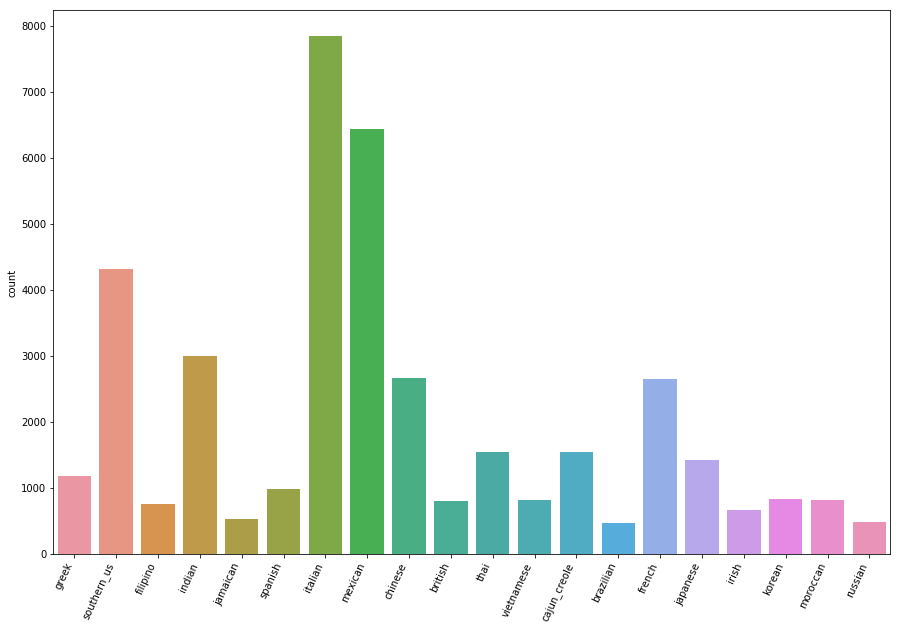

In [10]:
plt.figure(figsize=(15, 10))
chart = sns.countplot(cuisine)
ch = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')

In [11]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.5)

In [12]:
X = vectorizer.fit_transform(ingredients)

In [13]:
print(X.shape)

(39771, 1489)


In [14]:
LE = LabelEncoder()
labels = LE.fit_transform(cuisine)

In [15]:
labels

array([ 6, 16,  4, ...,  8,  3, 13])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)

In [19]:
def print_metrics(y_test, ans):
    print "Accuracy ~", np.round(accuracy_score(y_test, ans), 4)
    print "F1_score ~", np.round(f1_score(y_test, ans, average="macro"), 4)

# Stacking

# LR

In [20]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
lr_ans = LR.predict(X_test)

In [22]:
print_metrics(y_test, lr_ans)

Accuracy ~ 0.7789
F1_score ~ 0.6862


# RF

In [23]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
RF_ans = RF.predict(X_test)

In [25]:
print_metrics(y_test, RF_ans)

Accuracy ~ 0.7452
F1_score ~ 0.6426


In [26]:
X_train.shape

(26646, 1489)

In [29]:
RF_stack = RandomForestClassifier(n_estimators=100)
RF_stack.fit(LR.predict_proba(X_train), y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
RF_predict_proba = RF_stack.predict(LR.predict_proba(X_test))

In [31]:
print_metrics(y_test, RF_predict_proba)

Accuracy ~ 0.7901
F1_score ~ 0.7135


In [32]:
RF_stack.fit(np.hstack((X_train.toarray(), LR.predict_proba(X_train))), y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
RF_ans_stack = RF_stack.predict(np.hstack((X_test.toarray(), LR.predict_proba(X_test))))

In [34]:
LR.predict_proba(X_test).shape

(13125, 20)

In [35]:
np.hstack((X_test.toarray(), LR.predict_proba(X_test))).shape

(13125, 1509)

In [36]:
print_metrics(y_test, RF_ans_stack)

Accuracy ~ 0.7954
F1_score ~ 0.7161


# Bootstrap

In [37]:
df["cuisine"].value_counts()

italian         7837
mexican         6437
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        466
Name: cuisine, dtype: int64

In [38]:
cuisine1 = "russian"
cuisine2 = "brazilian"

In [39]:
cuisine1_df = df[df["cuisine"] == cuisine1]
cuisine2_df = df[df["cuisine"] == cuisine2]

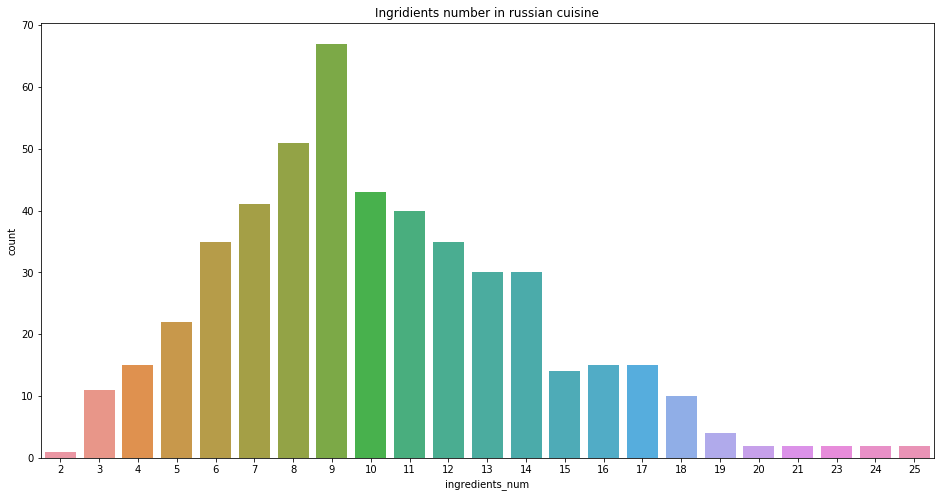

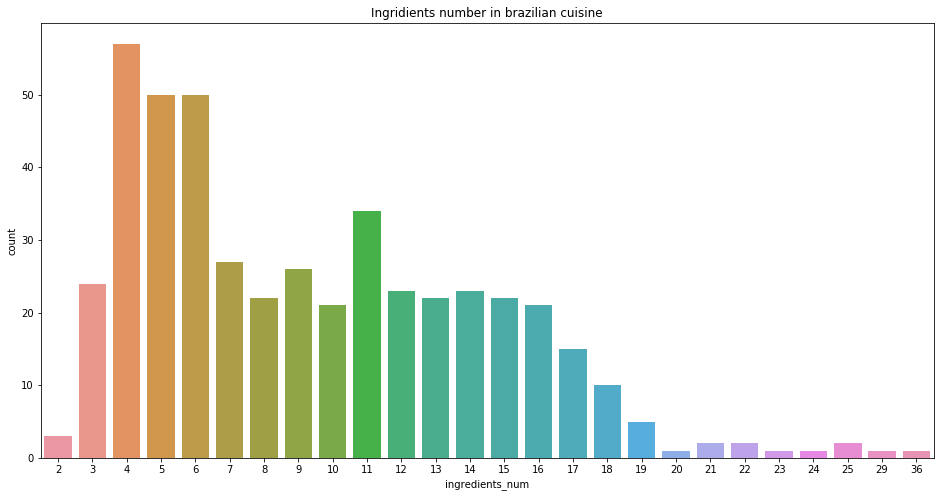

In [40]:
plt.figure(figsize=(16, 8))
plt.title("Ingridients number in {} cuisine".format(cuisine1))
sns.countplot(cuisine1_df["ingredients_num"])

plt.figure(figsize=(16, 8))
plt.title("Ingridients number in {} cuisine".format(cuisine2))
sns.countplot(cuisine2_df["ingredients_num"])

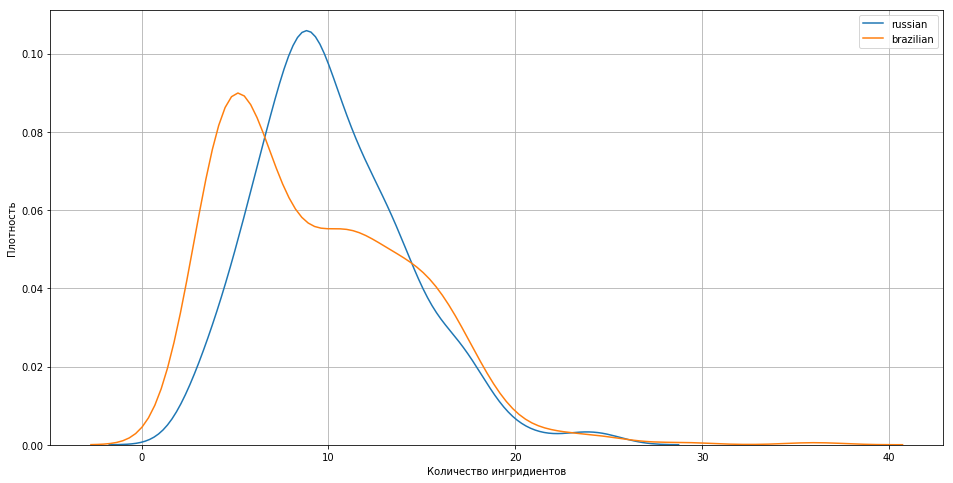

In [41]:
plt.figure(figsize=(16, 8))
fig = sns.kdeplot(cuisine1_df["ingredients_num"], label = cuisine1)
fig = sns.kdeplot(cuisine2_df["ingredients_num"], label = cuisine2)        
fig.set(xlabel=u'Количество ингридиентов', ylabel=u'Плотность')    
plt.grid()
plt.show()

Теперь было бы хорошо оценить, из скольки ингридентов в среднем состоят блюда каждой из кухонь. Так как данных в нашем датасете мало, то искать среднее не совсем правильно, лучше применить наши новые знания бутстрэпа.

In [42]:
def get_bootstrap_samples(data, n_samples):
    """Функция для генерации n_samples подвыборок с помощью бутстрэпа"""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [43]:
def stat_intervals(stat, alpha):
    """Функция для интервальной оценки"""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return np.round(boundaries, 4)

In [44]:
cuisine1_ingridients = cuisine1_df["ingredients_num"].values
cuisine2_ingridients = cuisine2_df["ingredients_num"].values

In [45]:
len(cuisine1_ingridients)

489

In [46]:
len(cuisine2_ingridients)

466

In [47]:
np.random.seed(42)

In [48]:
cuisine1_ingridients_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(cuisine1_ingridients, 5000)]
cuisine2_ingridients_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(cuisine2_ingridients, 5000)]

In [49]:
print "{} ingridients number:  mean interval".format(cuisine1),  stat_intervals(cuisine1_ingridients_scores, 0.05)
print "{} ingridients number:  mean interval".format(cuisine2),  stat_intervals(cuisine2_ingridients_scores, 0.05)

russian ingridients number:  mean interval [ 9.8732 10.591 ]
brazilian ingridients number:  mean interval [8.9464 9.8777]


In [50]:
print("""В итоге мы получили, что с 95% вероятностью среднее число ингридиентов в {} кухне будет лежать в промежутке между {r[0]} и {r[1]},  в то время как в {} в среднем от {b[0]} до {b[1]}"""
.format(cuisine1, cuisine2, r=stat_intervals(cuisine1_ingridients_scores, 0.05), b=stat_intervals(cuisine2_ingridients_scores, 0.05)))

В итоге мы получили, что с 95% вероятностью среднее число ингридиентов в russian кухне будет лежать в промежутке между 9.8732 и 10.591,  в то время как в brazilian в среднем от 8.9464 до 9.8777


# Бэггинг

In [51]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
DT_ans = DT.predict(X_test)

In [53]:
print_metrics(y_test, DT_ans)

Accuracy ~ 0.6126
F1_score ~ 0.4931


In [54]:
def most_frequent(List):
    return max(set(List), key = list(List).count)

# Bagging

In [55]:
n_estimators = 10
answer = np.zeros((n_estimators, X_test.shape[0]), dtype=int)

In [56]:
answer.shape

(10, 13125)

In [65]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [66]:
np.random.choice(np.arange(10), 5, replace=False)

array([0, 4, 6, 8, 7])

In [67]:
np.arange(X_train.shape[0])

array([    0,     1,     2, ..., 26643, 26644, 26645])

In [ ]:
X_train.shape[0]

In [68]:
for i in tqdm_notebook(range(n_estimators)):
    DT = DecisionTreeClassifier()
    index = np.random.choice(np.arange(X_train.shape[0]), X_train.shape[0])
    DT.fit(X_train[index], y_train[index])
    answer[i] = DT.predict(X_test)

In [75]:
bagging_dt_answer = [most_frequent(answer[:, i]) for i in range(answer.shape[1])]

In [76]:
print_metrics(y_test, bagging_dt_answer)

Accuracy ~ 0.6883
F1_score ~ 0.5841


# RSM 

In [77]:
n_estimators = 10
answer = np.zeros((n_estimators, X_test.shape[0]), dtype=int)

In [78]:
X_train.shape

(26646, 1489)

In [82]:
for i in tqdm_notebook(range(n_estimators)):
    DT = DecisionTreeClassifier()
    features = np.random.choice(np.arange(X_train.shape[1]), X_train.shape[1] // 2, replace=False)
    DT.fit(X_train[:, features], y_train)
    answer[i] = DT.predict(X_test[:, features])

In [83]:
rsm_dt_answer = [most_frequent(answer[:, i]) for i in range(answer.shape[1])]

In [81]:
print_metrics(y_test, rsm_dt_answer)

Accuracy ~ 0.6232
F1_score ~ 0.5066


In [84]:
print_metrics(y_test, rsm_dt_answer)

Accuracy ~ 0.7138
F1_score ~ 0.6043


# Random Forest

In [85]:
class RandomForest():
    
    def __init__(self, n_estimators=20, max_depth=None, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees_ = [] # 
        self.features_idx = []
        self.random_state = random_state

    def fit(self, X, y):
        self.X = X
        self.y = y
        for t in tqdm_notebook(range(self.n_estimators)):               
            # выбираем базовый алгоритм - дерево
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            # сэмплируем объекты
            index = np.random.choice(np.arange(X.shape[0]), X.shape[0])
            # сэмплируем признаки
            features = np.random.choice(np.arange(X.shape[1]), X.shape[1] // 2, replace=False)
            # обучаем
            tree.fit(X[index][:, features], y[index])
            # добавляем алгоритм к ансамблю
            self.trees_.append(tree)
            # добавляем признаки
            self.features_idx.append(features)
                   
        return self
    
    def predict(self, X):
        answer = np.zeros((len(self.trees_), X.shape[0]), dtype=int)
        # добавляем прогнозы деревьев
        for t in range(len(self.trees_)):
            answer[t] = self.trees_[t].predict(X[:, self.features_idx[t]])
            
        return np.array([most_frequent(answer[:, i]) for i in range(answer.shape[1])])

In [86]:
RF = RandomForest(n_estimators=20)
RF.fit(X_train, y_train)

<__main__.RandomForest instance at 0x7f4be3674710>

In [87]:
RF_ans = RF.predict(X_test)

In [ ]:
Accuracy ~ 0.7138
F1_score ~ 0.6043

In [88]:
print_metrics(y_test, RF_ans)

Accuracy ~ 0.7083
F1_score ~ 0.5964


# Ограничим датасет для быстроты подбора параметров

british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        466

In [89]:
cutted_labels = LE.transform(["british", "filipino", "irish", "jamaican", "russian", "brazilian", "spanish"])

In [90]:
idx = []
for i in range(len(labels)):
    if labels[i] in cutted_labels:
        idx.append(i)
idx = np.array(idx)

In [91]:
idx

array([    2,     5,     6, ..., 39763, 39766, 39768])

X, y = X[idx], labels[idx]

In [92]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [96]:
y = labels

In [97]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
temp_train_acc = []
temp_test_acc = []
temp_train_f1 = []
temp_test_f1 = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    RFC.fit(X_train, y_train)
    temp_train_acc.append(accuracy_score(RFC.predict(X_train), y_train))
    temp_train_f1.append(f1_score(RFC.predict(X_train), y_train, average="macro"))
    temp_test_acc.append(accuracy_score(RFC.predict(X_test), y_test))
    temp_test_f1.append(f1_score(RFC.predict(X_test), y_test, average="macro"))

In [98]:
print "f1_score is", np.round(np.mean(temp_test_f1), 5)
print "accuracy is", np.round(np.mean(temp_test_acc), 5)

f1_score is 0.64814
accuracy is 0.74733


In [99]:
parameters = {'max_features': [1, 5, 6], 
              'min_samples_leaf': [1, 3, 5, 7],
              'max_depth': [5, 10, 15, 20, 30, 50]}
rfc = RandomForestClassifier(random_state=42, 
                             n_jobs=18, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=18, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    9.2s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   16.6s
[Parallel(n_jobs=18)]: Done 360 out of 360 | elapsed:   24.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=18,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'max_features': [1, 5, 6], 'max_depth': [5, 10, 15, 20, 30, 50], 'min_samples_leaf': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [100]:
gcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=18,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [101]:
gcv.best_score_

0.6328983430137537

# Градиентный Бустинг

# Для простоты рассмотрим регрессию

In [102]:
from sklearn.metrics import mean_squared_error as mse

In [103]:
wine = pd.read_csv("winequality-red.csv")

In [106]:
X = wine.values[:, :-1]
y = wine.values[:, -1]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(wine.values[:, :-1], wine.values[:, -1], test_size=0.33, random_state=42)

$MSE(y, p) = \frac{1}{n} (y-p)^T(y-p) = \frac{1}{n} \sum\limits_{i=1}^n(y_i - p_i)^2$

$\nabla_{p_j} MSE - ?$

Каждый следующий алгоритм тоже будем настраивать на остатки предыдущих

Заметим, что остатки могут быть найдены как антиградиент функции потерь по ответу модели, посчитанный в точке ответа уже построенной композиции

In [110]:
np.mean(y) * np.ones(len(y))

array([5.63602251, 5.63602251, 5.63602251, ..., 5.63602251, 5.63602251,
       5.63602251])

In [111]:
class GradientBoosting():
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42):  
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones(len(y))
        self.loss_by_iter = [] # функция потерь на каждой итерации
        self.trees_ = []
        self.random_state = random_state
        
    def mse_grad(self, y, p):
        # написать градиент
        return 2. * (p - y) / len(y)

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        prediction = b.copy()
        for t in tqdm_notebook(range(self.n_estimators)):               
            # считаем - антиградиент
            resid = -self.mse_grad(y, prediction)
            # выбираем базовый алгоритм
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            # обучаемся на векторе антиградиента
            tree.fit(X, resid)
            # делаем предикт и добавляем алгоритм к ансамблю
            b = tree.predict(X)
            #добавляем дерево в ансамбль
            self.trees_.append(tree)
            # обновляем текущее приближение (lr * b)
            prediction += self.learning_rate * b
            # обновляем лосс на обучении (опционально)
            self.loss_by_iter.append(mse(y, prediction))
            
        return self
    
    def predict(self, X):
        # сначала инициализируем прогноз на тестовой выборке – 
        # это просто вектор из средних значений ответов на обучении
        pred = np.ones(X.shape[0]) * np.mean(self.y)
        # добавляем прогнозы деревьев * lr
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X)
            
        return pred

In [112]:
tree = GradientBoosting(n_estimators=500, learning_rate=1., max_depth=None)
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.46299196213134935

In [114]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.7026515151515151

In [117]:
tree = GradientBoostingRegressor(n_estimators=500, learning_rate=1., max_depth=None)
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.6704545454545454

In [118]:
class StohasticGradientBoosting():
    
    def __init__(self, n_estimators=500, learning_rate=0.1, max_depth=-1, random_state=42):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones(len(y))
        self.loss_by_iter = [] # функция потерь на каждой итерации
        self.trees_ = []
        self.random_state = random_state
        
    def mse_grad(self, y, p):
        # написать градиент
        return 2. * (p - y) / len(y)

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        prediction = b.copy()
        for t in tqdm_notebook(range(self.n_estimators)):  
            index = np.random.choice(np.arange(X.shape[0]), X.shape[0])
            # считаем - антиградиент
            resid = -self.mse_grad(y, prediction)
            # выбираем базовый алгоритм
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            # обучаемся на векторе антиградиента
            tree.fit(X[index], resid[index])
            # делаем предикт и добавляем алгоритм к ансамблю
            b = tree.predict(X)
            #добавляем дерево в ансамбль
            self.trees_.append(tree)
            # обновляем текущее приближение (lr * b)
            prediction += self.learning_rate * b
            # обновляем лосс на обучении (опционально)
            self.loss_by_iter.append(mse(y, prediction))
            
        return self
    
    def predict(self, X):
        # сначала инициализируем прогноз на тестовой выборке – 
        # это просто вектор из средних значений ответов на обучении
        pred = np.ones(X.shape[0]) * np.mean(self.y)
        # добавляем прогнозы деревьев * lr
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X)
            
        return pred

In [119]:
tree = StohasticGradientBoosting(n_estimators=500, learning_rate=1, max_depth=None)
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.3976889057979146

In [122]:
from lightgbm import LGBMRegressor, LGBMClassifier

LGBM = LGBMRegressor(n_estimators=500, learning_rate=0.1)
LGBM.fit(X_train, y_train.ravel())
LGBM_ans = LGBM.predict(X_test)
mse(y_test, LGBM_ans)

0.41309086015684054